# Neural Nets Tutorial - Part 2 (Draft)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

<p style="font-weight:600; font-family:'Helvetica';font-size:24px;color:blue">
    Gradient Descent - Introduction
</p>

Gradient descent is a technique that helps us set the correct values for neural network parameters.  Without gradient descent, networks wouldn't be able to learn how to make predictions from data.  In this notebook, we'll learn about gradient descent by using it to train a linear regression model.

Linear regression is a popular supervised machine learning algorithm that predicts a target given some input variables called predictors.  We'll use linear regression to predict tomorrow's temperature using historical data:

In [257]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zutils as utils
import pprint as pp
import math

In [52]:
# Read in the data
data = pd.read_csv("data/clean_weather.csv", index_col=0)
# Fill in any missing values in the data with past values
data = data.interpolate(limit_direction='both')

# Show the first 5 rows of the data
data.head()

,tmax,tmin,rain,tmax_tomorrow
1970-01-01,60.0,35.0,0.0,52.0
1970-01-02,52.0,39.0,0.0,52.0
1970-01-03,52.0,35.0,0.0,53.0
1970-01-04,53.0,36.0,0.0,52.0
1970-01-05,52.0,35.0,0.0,50.0


In [54]:
print('data shape:', data.shape)

data shape: (13509, 4)


## Linear regression intuition
In our data, each row is a different day, and the columns are different weather observations associated with that day.  We have data from `1970` to the present.

Using the data above, we could predict `tmax_tomorrow` based on today's max temperature (`tmax`), today's min temperature (`tmin`), and how much it rained today (`rain`).

Linear regression requires a linear relationship between the predictors and the target.  If two values have a linear relationship, when one value changes, the other value changes proportionally.  We can visualize this with a scatter plot:

<Figure size 900x500 with 0 Axes>

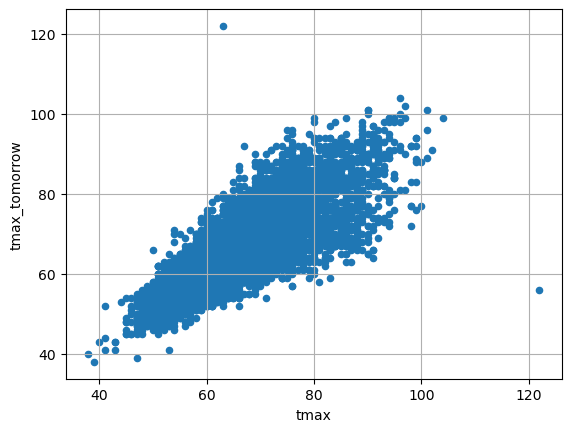

In [56]:
fig = plt.figure(figsize=(9,5))
data.plot.scatter('tmax', 'tmax_tomorrow')
plt.grid()
plt.show()

The above green line is multiplying `tmax` by `1` to get our predicted `tmax_tomorrow`.

## Linear Regression Equation

Linear regression works in a similar way - it learns the correct values to multiply the predictors by to get the target.  The equation for this looks like:

$ \large \hat{y}=w_{1}x_{1} + w_{2}x_{2} + w_{3}x_{4} + b $

- $\hat{y}$ is our prediction for `tmax_tomorrow`.
- $x_{1}$, $x_{2}$, and $x_{3}$ are the predictors that we're using to predict the target (in this case, `tmax`, `tmin`, and `rain`).  If we had more predictors, we would add more x values to our equation.
- The $w$ values are the weight parameters that the linear regression algorithm learns.  The weights are what we multiply the $x$ values by to get the predicted $\hat{y}$ value.
- $b$ is a value called the bias (or y-intercept).  This enables us to "shift" the prediction line up or down to match the data.  Without a bias, if our predictors are all `0`, then our prediction will also be `0`.

Let's take a look at how a linear regression model works.  To simplify things, we will go with just a single predictor (`tmax`).

In [67]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(data[['tmax']], data['tmax_tomorrow'])

LinearRegression()

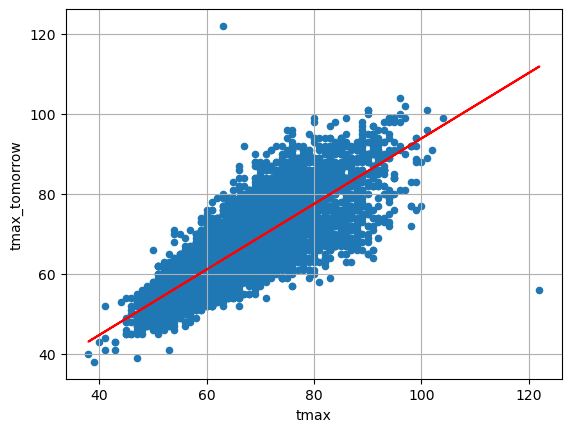

Linear Regression --> Weight: 0.82 Bias: 11.97


In [86]:
# plt.figure(figsize=(9,5))
data.plot.scatter('tmax', 'tmax_tomorrow')
plt.plot(data['tmax'], lr.predict(data[['tmax']]), color='red')
plt.grid()
plt.show()

print(f'Linear Regression --> Weight: {lr.coef_[0]:.2f}', f'Bias: {lr.intercept_:.2f}')

## Measuring Loss

Our predictions for `tmax_tomorrow` will be $\hat{y}=.82 * \text{tmax} + 11.97$.  Now let's learn how to build our own linear regression algorithm.

## Calculating Loss

Earlier, I mentioned that we'd train our linear regression algorithm using gradient descent.  To make gradient descent work, we first need to calculate our loss.

Let's say today's `tmax` is `80`.  Using the equation, we can calculate our predicted `tmax_tomorrow` to be `77.59`. Then we can calculate our loss.  Loss is a measure of the difference between the actual values and our predictions.  With linear regression, it's common to use squared error.  We calculate it using the formula $\large \text{MSE}=(\hat{y} - y) ^ 2$.

If the actual `tmax_tomorrow` is `81`, then our loss is $\large (77.59 - 81) ^ 2$, which equals `11.63`.

Our parameters (weight and bias) led to this loss value.  If we change the weight, our loss will also change.  Let's visualize what it would look like if our weight value was `1`.


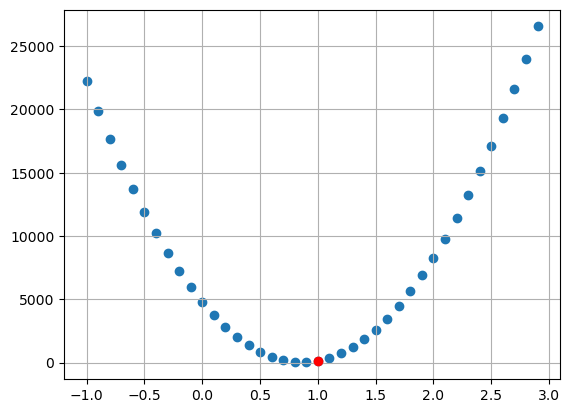

In [127]:
weight = lr.coef_[0]
bias = lr.intercept_
tmax = 80
y = 81 # factual data (ground true)

ws = np.arange(-1, 3, .1)
pred = ws * tmax + bias

loss = lambda w, y: ((w * tmax + bias) - y)**2

losses = loss(ws, y)
plt.scatter(ws, losses)
plt.grid()
plt.plot(1, loss(1, y), 'ro')

Text(0, 0.5, 'Loss function')

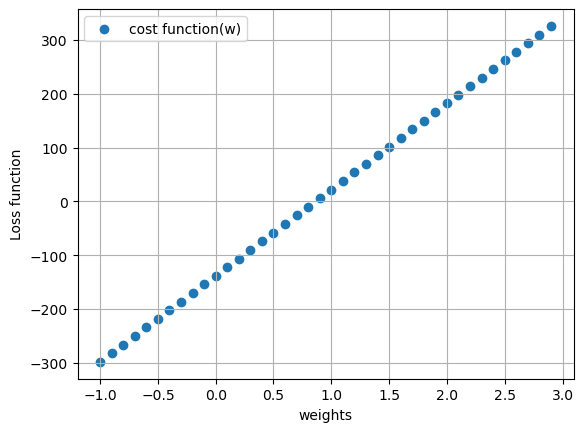

In [133]:
gradient = lambda w, y: 2 * ((w*tmax + bias) - y)
gradients = gradient(ws, y)
plt.grid()
plt.scatter(ws, gradients, label='cost function(w)')
plt.legend()
plt.xlabel('weights')
plt.ylabel('Loss function')

## Parameter updates

In the plot above, we've graphed the weight values on the x-axis, and the corresponding losses on the y-axis.  As you can see, there is a value at the bottom of the graph where loss is the lowest.  Loss increases if the weight is higher or lower than that value.  This is called the global minimum, and it's our goal to reach this value.

We've marked our weight value of `1` in red.  It's close to the global minimum, but not quite there.  This is where gradient descent comes into play - it helps us adjust our parameters to reduce loss.

First, we calculate the loss when the weight is `1`.  This equals `120.78` - $((1 * 80 + 11.99) - 81) ^ 2$.  We then have to figure out how much each parameter contributes to that loss.

## Parameter Updates

To understand how we do this, let's first take a look at the operations we perform to get a prediction.  This can also be called a computational graph:

<img src="images/linreg/gradient.svg" width=600 />

As you can see, we take our input data (`tmax`), multiply it by the weight $w$, then add in the bias $b$ to get our prediction.

To make the prediction closer to the correct value, we need to adjust $w$ and $b$.  We need to know how much to adjust them, and in which direction (up or down).

To figure this out, we take the partial derivative of the loss against $w$ and $b$.  This is a math way of saying "we're going to figure out how much each parameter contributes to our loss".

We start by calculating the gradient of our loss.  This tells us how quickly our loss is changing.  We want to move in the direction where loss is decreasing the fastest.  We can calculate this by taking the derivative of our loss metric, which is $2 * (\hat{y} - {y})$. This shows us how quickly our loss is changing:

# Loss and Partial Derivatives
If our weight is above a certain value (around `.82`), then our gradient is positive, and our predictions are too large.  If it is below the value, then our gradient is negative, and our predictions are too small.  Our current gradient is `21.98` - $((1 * 80 + 11.99) - 81) * 2$

With gradient descent, our goal is to get to a place where the gradient is close to `0` (our predictions match the actual values).  Hopefully this area will be a global minimum. Sometimes it will be a local minimum instead, which we'll discuss further later on.

The partial derivative with respect to the loss gradient tells us how much to adjust each parameter to lower the loss.  First, let's take the partial derivative with respect to $b$:

$\Large \frac{\partial L}{\partial b}=\partial L$ <font size=5>= gradient(L)</font>

The intuitive way to think about this is "how would I change $b$ if I wanted to get the predictions closer to the actuals?".  Because you add $b$ to $x * w$ to get the prediction, any change to $b$ directly impacts the prediction.  So the partial derivative of $b$ with respect to the loss is the same as the loss!

<img src="images/linreg/b_deriv.svg" width=600 />

Next, we take the partial derivative with respect to $w$.  This is a little more complicated, since we multiply $w$ by $x$, then add it to $b$ to get our prediction:

$\Large \frac{\partial L}{\partial w}=\frac{\partial L}{\partial (x \cdot w)}\frac{\partial (x \cdot w)}{\partial w}$

We use the chain rule to find the derivative.  The chain rule says that the partial derivative of $a$ with respect to $c$ equals the partial derivative of $a$ with respect to $b$ times the partial derivative of $b$ with respect to $c$.

Similar to what we saw with $\Large b$, $\Large \frac{\partial L}{\partial (x \cdot w)}$ is just the same as $\partial L$, since we add $x*w$ to $b$ to get the loss.

So we can update the equation to:

$\Large \frac{\partial L}{\partial w}=\partial L\frac{\partial (x \cdot w)}{\partial w}$

Since we multiply $w$ by $x$, any change to $w$ will change the prediction proportional to $x$.  So:

$\Large \frac{\partial L}{\partial w}=\partial L \cdot x = gradient(L) \cdot x $

<img src="images/linreg/w_deriv.svg" width=600 />

After calculating the partial derivatives, we update our $w$ and $b$ values by subtracting the partial derivatives from the current values.  We don't want to subtract the entire partial derivative, though - this would change the weight too much:

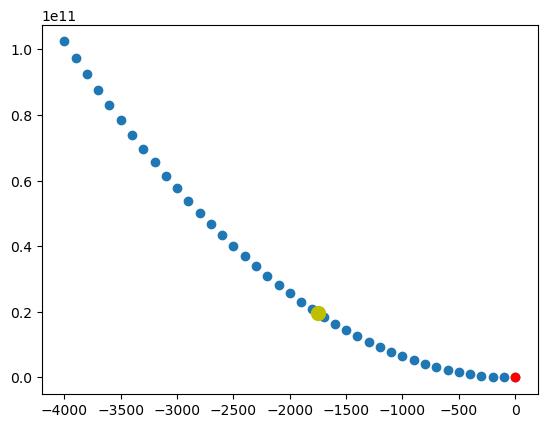

In [157]:
ws = np.arange(-4000,100,100)
losses = loss(ws, y)

# Plot the weight and losses
plt.scatter(ws, losses)

# Original weight
plt.plot(1, loss(1, y), 'ro')
# New weight
new_weight = 1 - gradient(1,y) * tmax
plt.plot(new_weight, loss(new_weight, y), 'yo', markersize=10)

## Learning Rate

Above, you can see the original weight in red, and the new weight is in green.  You might notice that the error is actually higher with the new weight.  This is because we took too large of a step.  This is a common problem with gradient descent - we adjust our parameters so much that we overshoot the minimum and end up with higher error.

This happens because the partial derivative doesn't know that the gradient will change in between the old weight value and the new weight value.  Since we're taking the derivative at a single point, it assumes that the gradient will stay constant.  Instead, as we can see in the chart below, the gradient changes quite a bit between the old weight and the new weight:

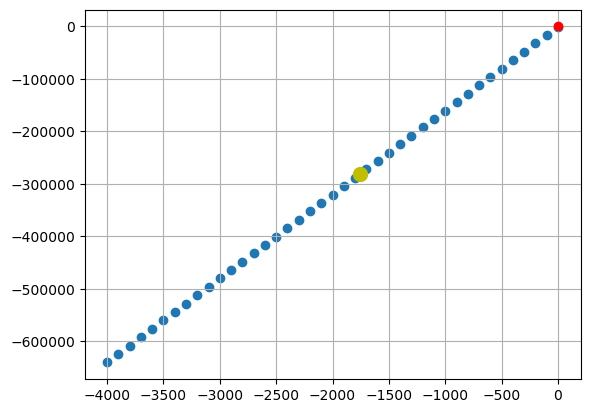

In [179]:
# Calculate gradient values for several weights
gradients = gradient(ws, y)

# Plot the weight and gradients
plt.scatter(ws, gradients)
plt.plot(1, gradient(1, y), 'ro')
# New weight
plt.plot(new_weight, gradient(new_weight, y), 'yo', markersize=10)
plt.grid()
plt.show()

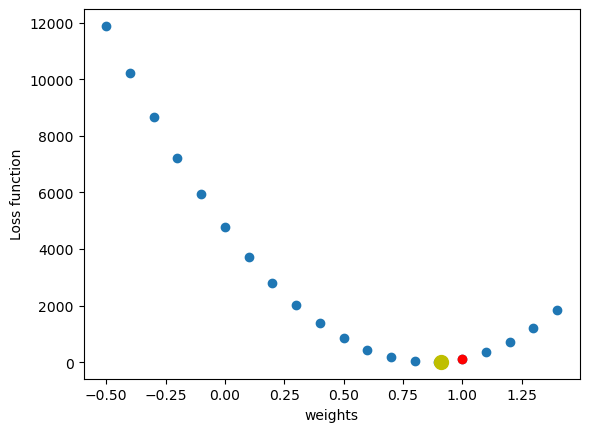

In [190]:
ws = np.arange(-0.5, 1.5, 0.1)
losses = loss(ws, y)

# Plot the weight and losses
plt.xlabel('weights')
plt.ylabel('Loss function')
plt.scatter(ws, losses)

# Original weight
plt.plot(1, loss(1, y), 'ro')
# New weight with learning rate
learning_rate = 5e-5
new_weight = 1 - learning_rate * gradient(1, y) * tmax
plt.plot(new_weight, loss(new_weight, y), 'yo', markersize=10)

## Implementation of Linear Regression
Let's first load our data and split it into 3 sets:

- A training set, which we'll use to train our algorithm
- A validation set, which we'll use to measure error during training
- A test set, which we'll use to evaluate the model after it has been fit

Creating separate sets like this helps us avoid overfitting, where our model looks great in training, but doesn't work in the real world.

In [323]:
PREDICTORS = ["tmax", "tmin", "rain"]
TARGET = "tmax_tomorrow"

# Ensure we get the same split every time
np.random.seed(0)
print(data.shape)

N1 = int(0.70 * len(data))
N2 = int(0.85 * len(data))
print('Indices:', N1, N2, N2 - N1)

# splits in the parts [0:N1], [N1:N2], [N2:end]
# split_data = np.split(data, [N1, N2]) # deprecated

split_data = data.iloc[:N1], data.iloc[N1:N2], data.iloc[N2:]

# print(split_data)
print('data lengths:', len(split_data[0]), len(split_data[1]), len(split_data[2]))
print('Tota data:', len(split_data[0])+len(split_data[1])+len(split_data[2]))

(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = \
        [[d[PREDICTORS].to_numpy(), d[[TARGET]].to_numpy()] for d in split_data]
print(f'train_x.shape: {train_x.shape}')

(13509, 4)
Indices: 9456 11482 2026
data lengths: 9456 2026 2027
Tota data: 13509
train_x.shape: (9456, 3)


## Train a linear regression algorithm
To train a linear regression algorithm using gradient descent, we need 4 elements:

1. A way to `initialize` our parameters (weights and biases)
1. A `forward` pass that computes predictions using the parameters
1. A `loss function` that measures the error of our predictions
1. A `backward` pass that updates our parameters to reduce the loss

To initialize our weight parameters, we can use random initialization.  Random initialization helps the gradient descent algorithm descend to a global minimum efficiently (feel free to experiment with other initializations, like 0 or 1 to see what happens).

It's common to initialize the bias to be `1` or `0`.

We'll shrink the initial parameter values so we don't end up with predictions that are too large (this can cause gradient descent to take steps that are too large).

In [530]:
def init_params(predictors, scale_params=False):
    '''
    Initializes weight and biases. 
    predictors = number of predictors to initialize
    '''
    # k is a scaling factor that we use to reduce the weights and biases initially
    k = math.sqrt(1 / predictors)
    np.random.seed(0)
    if scale_params:   
        weights = np.random.rand(predictors,1) * 2 * k - k
        biases = np.ones([1,1]) * 2 * k - k
    else:
        weights = np.random.rand(predictors,1)
        biases = np.ones([1,1])
    return [weights, biases]

def forward(params, x):
    weights, biases = params
    prediction = x @ weights + biases
    return prediction

def mse(actual, predicted):
    '''
    Mean squared Error function
    '''
    return np.mean((predicted - actual)**2)

def mse_grad(actual, predicted):
    '''
    Gradient of MSE function
    '''
    return predicted - actual # we drop the factor of 2 for convenience

def backward(params, x, learning_rate, grad):
    '''
    Backward pass to modify params
    x, grad are column vectors, so to multiply we need to transpose
    '''
    w_grad = (x.T / x.shape[0]) @ grad # take the mean of x-values    
    b_grad = np.mean(grad, axis=0) # the mean value of bias
    
    # print(x.T)
    # print(grad)
    # print(w_grad)
    
    params[0] -= learning_rate * w_grad # update the weights
    params[1] -= learning_rate * b_grad # update the bias
    
    return params


## Training loop

Finally, we'll write a loop that:

1. Makes predictions for the whole training set
1. Computes the gradient for each training example
1. Updates the parameters based on the gradient

We will run the algorithm for several epochs - an epoch is each iteration over the training set.  Up to a point, more epochs will improve the accuracy.

We will print out the loss on the validation set regularly so we can monitor the loss.  We know we have too many epochs if the validation loss is increasing instead of decreasing.

Epoch: 0 loss = 31.559726171913173
Epoch: 500 loss = 24.154817389663236
Epoch: 1000 loss = 22.98085242312496
Epoch: 1500 loss = 22.72952922223889
Epoch: 2000 loss = 22.660650105278275
Epoch: 2500 loss = 22.63752195857853
Epoch: 3000 loss = 22.628341561957217
Epoch: 3500 loss = 22.623913231336246
Epoch: 4000 loss = 22.62118767678248
Epoch: 4500 loss = 22.61908547163964
--------------------------------------------------
weights: [0.79594201 0.2410204  0.57190988]
bias: [1.05006212]
--------------------------------------------------



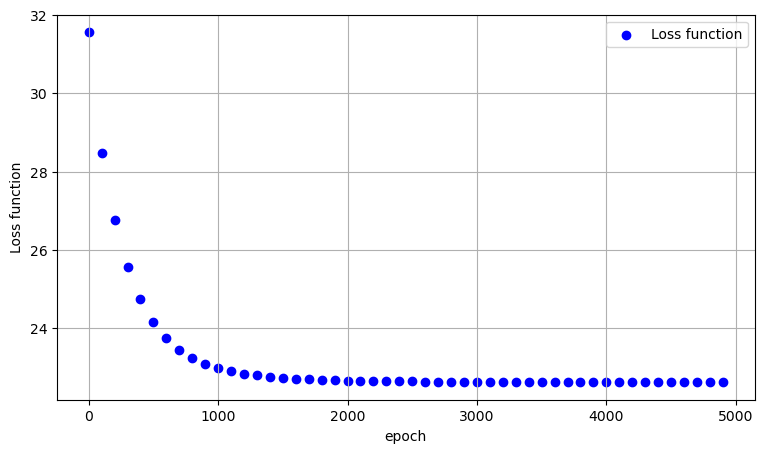

In [532]:
# Careful with the value of the learning rate
# too low inhibits training, and too high overshoots
learning_rate = 1.e-4 
epochs = 5_000
params = init_params(train_x.shape[1], scale_params=False)

# Store weights and gradients so we can visualize
# Not necessary for algorithm
sample_rate = 100
samples = int(epochs / sample_rate)
historical_ws = np.zeros((samples, train_x.shape[1]))
historical_grad = np.zeros((samples,))

valid_losses = []
valid_epochs = []
for epoch in range(epochs):
    # forward pass, yields a column vector with prediction values
    predictions = forward(params, train_x) # each row of data spits a number
    # compute gradient of loss function, yileds a column vector with grad values
    grad = mse_grad(train_y, predictions)
    # backward pass to set new param values, train_x, grad column vectors
    params = backward(params, train_x, learning_rate, grad)
    
    if epoch % sample_rate == 0:
        predictions = forward(params, valid_x)
        valid_loss = mse(valid_y, predictions)
        valid_losses.append(valid_loss)
        valid_epochs.append(epoch)
        # Store historical weights for visualization
        index = int(epoch / sample_rate)
        historical_grad[index] = np.mean(grad)
        historical_ws[index,:] = params[0][:,0]
        
        if epoch % 500 == 0:
            print(f'Epoch: {epoch} loss = {valid_loss}')

utils.hr(50)
w = params[0][:,0]
b = params[1][:,0]
print('weights:', w)
print('bias:', b)
utils.hr(50)
print()

plt.figure(figsize=(9,5))
plt.scatter(valid_epochs, valid_losses, color='blue', label='Loss function')
plt.xlabel('epoch')
plt.ylabel('Loss function')
plt.legend()
plt.grid()
plt.show()

[ 7.60343374 -0.08802873 -0.09102252 -0.09347404 -0.0954811  -0.0971239
 -0.09846814 -0.09956769 -0.10046669 -0.10120131 -0.10180122 -0.10229071
 -0.1026897  -0.10301453 -0.10327857 -0.10349278 -0.10366616 -0.10380607
 -0.10391855 -0.10400855 -0.10408013 -0.10413661 -0.1041807  -0.10421466
 -0.1042403  -0.10425913 -0.10427237 -0.10428103 -0.10428595 -0.10428779
 -0.10428712 -0.10428437 -0.10427994 -0.10427412 -0.10426716 -0.10425928
 -0.10425063 -0.10424135 -0.10423157 -0.10422136 -0.10421081 -0.10419998
 -0.10418892 -0.10417767 -0.10416627 -0.10415473 -0.1041431  -0.10413138
 -0.1041196  -0.10410775]


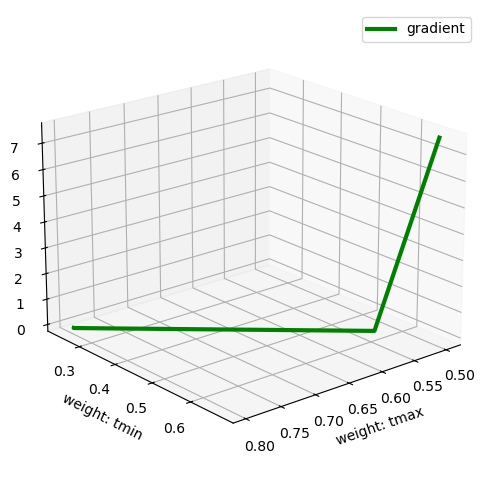

In [459]:
# PLOT HISTORICAL WEIGHTS AND GRADIENTS

print(historical_grad)

# Create a figure and a 3D axis
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')
ax.view_init(20,50)

ax.set_xlabel('weight: tmax')
ax.set_ylabel('weight: tmin')

# Plot the path of the optimization algorithm
ax.plot3D(historical_ws[:,0], historical_ws[:,1], historical_grad, 'green', linewidth=3, zorder=10, label='gradient')
ax.legend()
# Show the plot
plt.show()

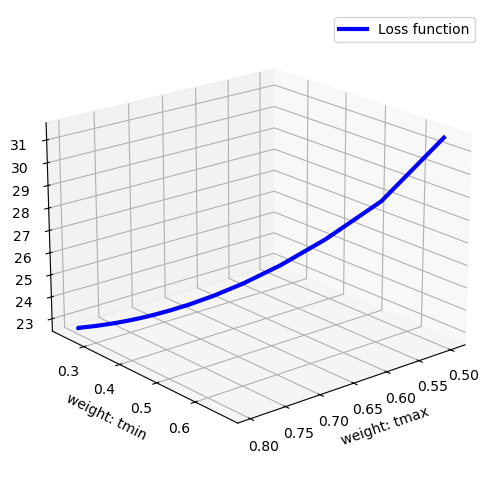

In [409]:
# Create a figure and a 3D axis
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')
ax.view_init(20,50)

ax.set_xlabel('weight: tmax')
ax.set_ylabel('weight: tmin')

# Plot the path of the optimization algorithm
ax.plot3D(historical_ws[:,0], historical_ws[:,1], valid_losses, 'blue', linewidth=3, zorder=10, label='Loss function')
ax.legend()
# Show the plot
plt.show()

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)